<a href="https://colab.research.google.com/github/fakejunior/GEOL0069-AI4EO-final-project/blob/main/GEOL0069_AI4EO_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Detection and Classification of Four Land Types in Southeast London and the English Channel Using KMeans Clustering

The objective of this study is to apply **unsupervised classification** to detect and extract **four land types** from **Sentinel-2 imagery** over the **southeastern part of London** and the **English Channel**. This study employs **KMeans clustering** to classify image pixels into four categories: **inland water bodies**, **marine water bodies**, **urban areas**, and **other land types**.

The analysis focuses on two specific regions: the **southeastern part of London**, which has a high density of small lakes and rivers suitable for detecting inland water bodies, and the **English Channel**, known for its marine water bodies. The challenge here is to distinguish between sea water and surrounding land. To enhance the distinction between water bodies and land, this study computes the **NDVI** and **NDWI** indices, which help separate water bodies from land features more effectively.


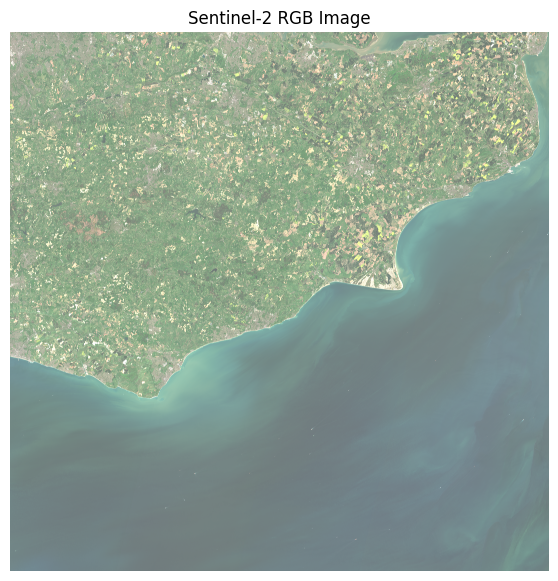

The approach begins by preprocessing the Sentinel-2 imagery using bands B2 (Blue), B3 (Green), B4 (Red), and B8 (NIR), and calculating NDVI and NDWI indices. Next, **KMeans clustering** is applied to classify the pixels into four categories, and the clustering results are visualized. **KMeans clustering** is a straightforward method that divides the data into clusters by updating cluster centroids, making it an efficient choice for this task.

To better understand the clustering results, this study uses **Explainable AI (XAI)** techniques to analyze the importance of each feature in the clustering process, with a focus on visualizing the importance of features that contribute to each cluster.

In addition to the RGB image and clustering results visualizations, radar charts are used to display the spectral profiles of the cluster centers and the pixel count distribution for each cluster, providing better interpretability of the results.

# **Mount Google Drive for Data Access**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Install Required Libraries**

In [ ]:
pip install rasterio


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 109.0 MB/s eta 0:00:00


In [ ]:
pip install netCDF4

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 10.0 MB/s eta 0:00:00


# **Read and Preprocess Sentinel-2 Band Data**

This section reads the band data from Sentinel-2 imagery and combines the individual bands (Blue, Green, Red, and NIR) into a stacked array. It also applies a mask to exclude invalid pixels (e.g., pixels with zero or missing values).

In [ ]:
import rasterio
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import pandas as pd

# File Path Configuration
base_path = "/content/drive/MyDrive/final/S2A_MSIL2A_20250429T105701_N0511_R094_T30UYB_20250429T192814.SAFE/GRANULE/L2A_T30UYB_A051457_20250429T110413/IMG_DATA/R10m/"
bands_paths = {
    'B2': base_path + 'T30UYB_20250429T105701_B02_10m.jp2',  # Blue
    'B3': base_path + 'T30UYB_20250429T105701_B03_10m.jp2',  # Green
    'B4': base_path + 'T30UYB_20250429T105701_B04_10m.jp2',  # Red
    'B8': base_path + 'T30UYB_20250429T105701_B08_10m.jp2',  # NIR
}

# Read the Band Data
band_data = []
for band in ['B2', 'B3', 'B4', 'B8']:
    with rasterio.open(bands_paths[band]) as src:
        band_data.append(src.read(1))

# Combine Bands and Mask Invalid Pixels
band_stack = np.dstack(band_data)  # shape: (H, W, 4)
valid_mask = np.all(band_stack > 0, axis=2)
X = band_stack[valid_mask]  # Only valid pixels: (n, 4)

# **Feature Enhancement and Data Preprocessing**

This section adds two important features, **NDVI** (Normalized Difference Vegetation Index) and **NDWI** (Normalized Difference Water Index), to the dataset. These indices are widely used for distinguishing water bodies and vegetation. After calculating **NDVI** and **NDWI**, the features are standardized to prepare for the clustering step.

**Formulas:**
- **NDVI (Normalized Difference Vegetation Index):**  
  $$
  \text{NDVI} = \frac{B8 - B4}{B8 + B4}
  $$  
  where \( B8 \) is the NIR band and \( B4 \) is the Red band.

- **NDWI (Normalized Difference Water Index):**  
  $$
  \text{NDWI} = \frac{B3 - B8}{B3 + B8}
  $$  
  where \( B3 \) is the Green band and \( B8 \) is the NIR band.


In [ ]:
# Compute NDVI and NDWI, Add to Features
B2, B3, B4, B8 = [band_data[i].astype(float) for i in range(4)]
NDVI = (B8 - B4) / (B8 + B4 + 1e-6)
NDWI = (B3 - B8) / (B3 + B8 + 1e-6)
# Standardize the other features (B2, B3, B4, B8)
X_features = np.hstack([X, NDVI[valid_mask][:, None], NDWI[valid_mask][:, None]])

# Standardize the bands (B2, B3, B4, B8) together
scaler_bands = StandardScaler()
X_bands_scaled = scaler_bands.fit_transform(X_features[:, :4])  # B2, B3, B4, B8

# Standardize NDVI and NDWI separately
scaler_ndvi_ndwi = StandardScaler()
ndvi_scaled = scaler_ndvi_ndwi.fit_transform(X_features[:, 4:5])  # NDVI
ndwi_scaled = scaler_ndvi_ndwi.fit_transform(X_features[:, 5:6])  # NDWI

# Combine scaled features back
X_scaled = np.hstack([X_bands_scaled, ndvi_scaled, ndwi_scaled])  # Final scaled feature matrix



# **KMeans Algorithm for Classification and Visualization**
This section applies the **KMeans** clustering algorithm to classify the data into four clusters. The clusters are visualized using **RGB image overlays** and **cluster center analysis**.

In [ ]:
# Apply KMeans Clustering
n_clusters = 4  # You can try with 3, 5, etc.
kmeans = KMeans(n_clusters=n_clusters, random_state=0, n_init=10).fit(X_scaled)
labels = kmeans.labels_

After clustering, the labels are restored to the original image dimensions. This allows us to visualize how the clusters correspond to specific spatial regions.



In [ ]:
# Restore Labels to Original Dimensions
labels_image = np.full(band_stack.shape[:2], -1, dtype=int)
labels_image[valid_mask] = labels

An RGB image is created using the Red, Green, and Blue bands. This image is visualized to show the raw satellite data, providing context for the clustering results.

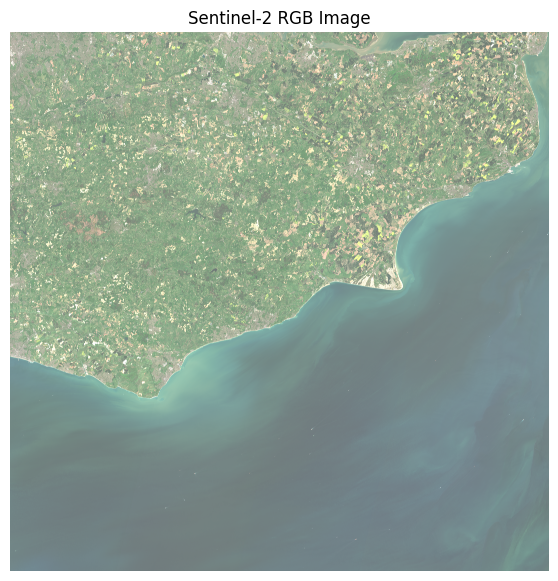

In [ ]:
rgb_img = np.stack([B4, B3, B2], axis=-1)  # R/G/B
plt.figure(figsize=(7, 7))
plt.imshow(np.clip(rgb_img / np.percentile(rgb_img, 99), 0, 1))
plt.title('Sentinel-2 RGB Image')
plt.axis('off')
plt.show()


The clustering result is visualized by overlaying the cluster labels on the image. Each cluster is assigned a unique color, providing a clear visual representation of how the data is classified.

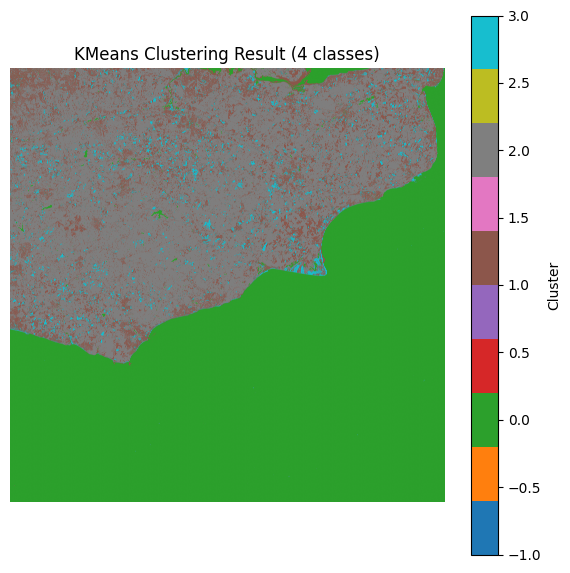

In [ ]:
plt.figure(figsize=(7, 7))
plt.imshow(labels_image, cmap='tab10')
plt.title(f'KMeans Clustering Result ({n_clusters} classes)')
plt.axis('off')
plt.colorbar(label='Cluster')
plt.show()

The cluster centers are analyzed to understand the importance of each feature in the classification. The centers are scaled back to the original feature space for interpretation.

In [ ]:
# Cluster Center Analysis (XAI)

# Reverse the scaling for the bands (B2, B3, B4, B8) - first 4 columns
centers_bands = scaler_bands.inverse_transform(kmeans.cluster_centers_[:, :4])

# Reverse the scaling for NDVI and NDWI - last 2 columns
centers_ndvi_ndwi = scaler_ndvi_ndwi.inverse_transform(kmeans.cluster_centers_[:, 4:])

# Combine the restored centers
centers = np.hstack([centers_bands, centers_ndvi_ndwi])

# Create a DataFrame for better readability
centers_df = pd.DataFrame(centers, columns=['B2', 'B3', 'B4', 'B8', 'NDVI', 'NDWI'])

# Normalize each column to make the sum of each column equal to 1
centers_df_normalized = np.abs(centers_df.div(centers_df.sum(axis=0), axis=1))

# Print the normalized cluster centers (sum of each column = 1)
print('\nCluster centers (normalized so that the sum of each column is 1):')
print(centers_df_normalized)



Cluster centers (normalized so that the sum of each column is 1):
         B2        B3        B4        B8      NDVI      NDWI
0  0.215706  0.187395  0.163381  0.079925  0.948631  0.125522
1  0.250933  0.256922  0.263392  0.283139  0.067109  0.355855
2  0.208437  0.221307  0.193822  0.355075  0.472519  0.535926
3  0.324924  0.334375  0.379404  0.281861  0.456779  0.233741


A radar chart is created to visualize the feature values for each cluster center. This helps us to understand the spectral and index profile of each cluster.

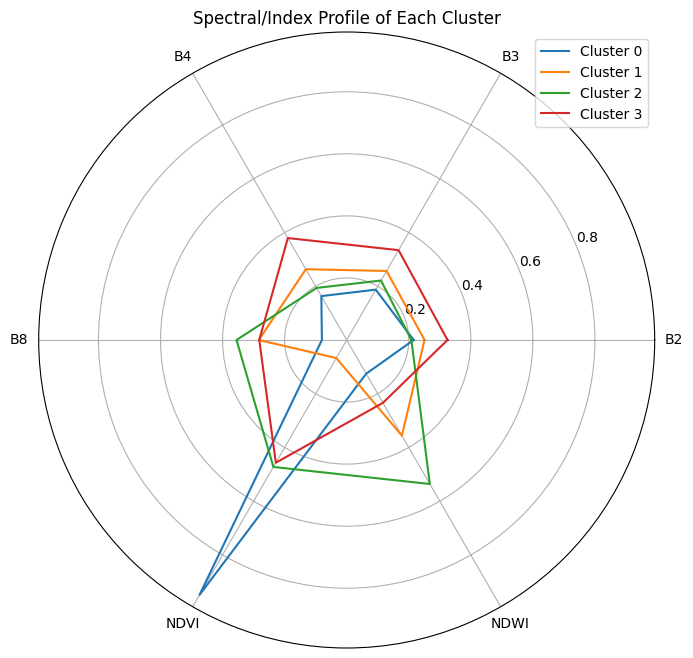

In [ ]:
categories = ['B2', 'B3', 'B4', 'B8', 'NDVI', 'NDWI']
angles = np.linspace(0, 2*np.pi, len(categories), endpoint=False).tolist()
angles += angles[:1]
plt.figure(figsize=(8, 8))
for i, row in centers_df_normalized.iterrows():
    values = row.tolist()
    values += values[:1]
    plt.polar(angles, values, label=f'Cluster {i}')
plt.xticks(angles[:-1], categories)
plt.title('Spectral/Index Profile of Each Cluster')
plt.legend()
plt.show()


The pixel count for each cluster is calculated to understand the distribution of the clusters in terms of pixel numbers. This is useful for interpreting the relative size of each cluster.

In [ ]:
counts = pd.Series(labels).value_counts().sort_index()
print('\nPixel count in each cluster:')
for i, count in counts.items():
    print(f'Cluster {i}: {count} pixels')



Pixel count in each cluster:
Cluster 0: 62316371 pixels
Cluster 1: 13709976 pixels
Cluster 2: 41060938 pixels
Cluster 3: 3473110 pixels


This step visualizes the RGB image with semi-transparent overlays representing each cluster. Each cluster is highlighted in a different color for easy distinction.

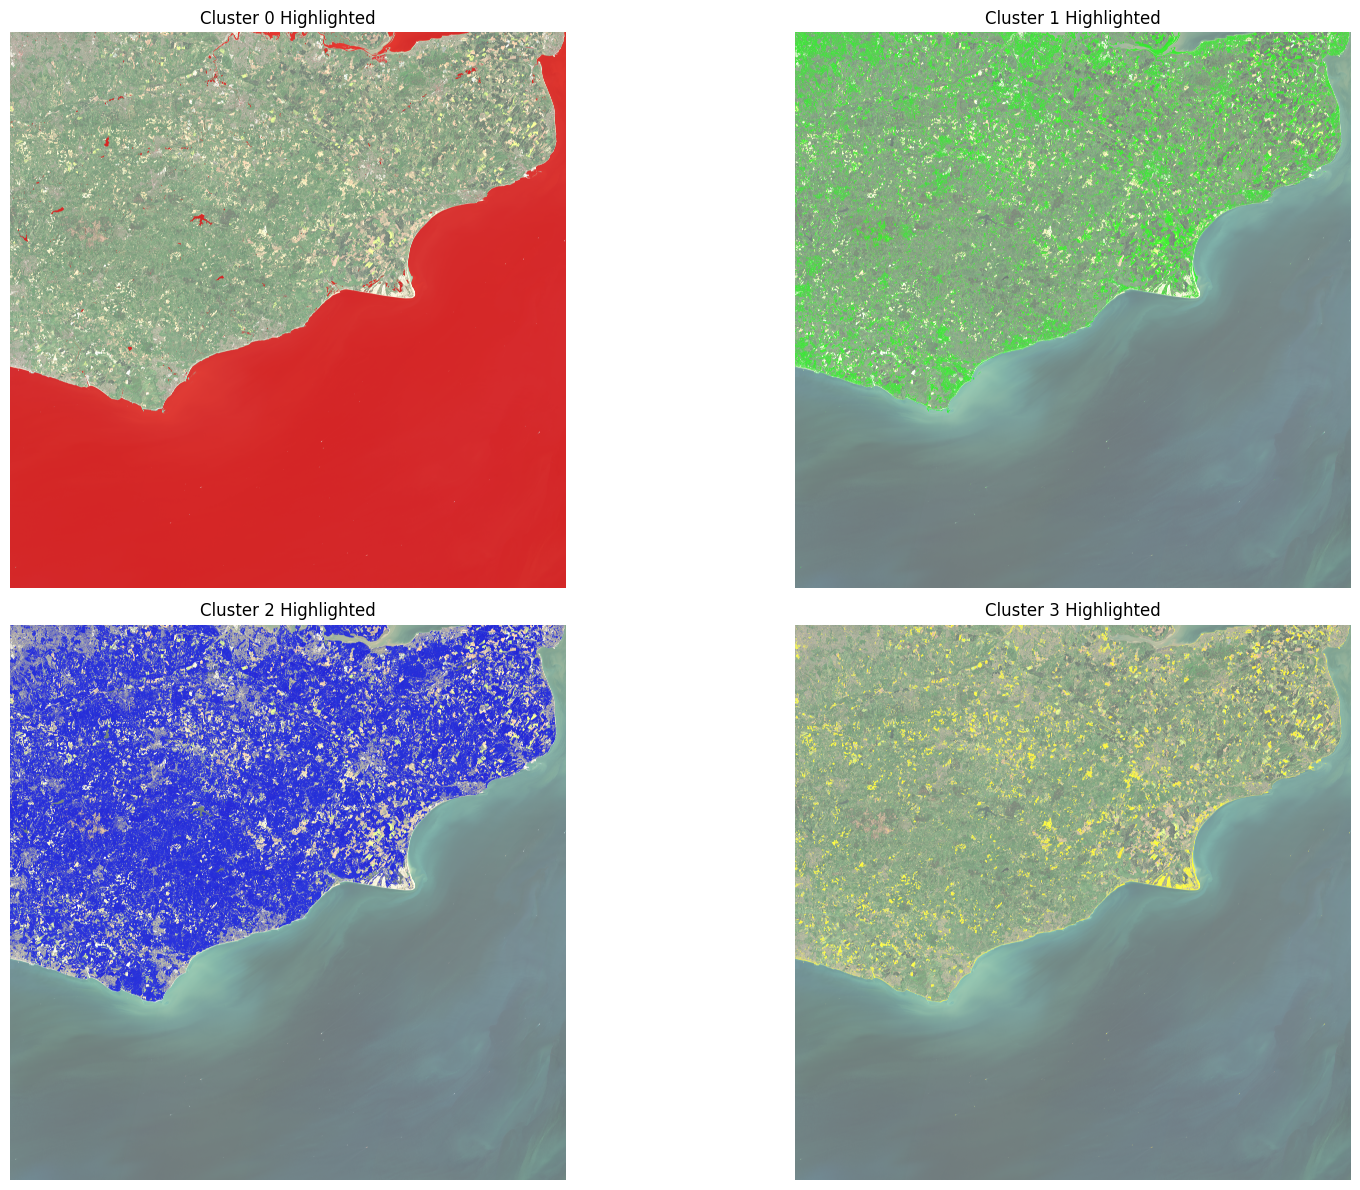

In [ ]:
rgb_norm = np.clip(rgb_img / np.percentile(rgb_img, 99), 0, 1)
mask_colors = [[1, 0, 0], [0, 1, 0], [0, 0, 1], [1, 1, 0]]  # Red, Green, Blue, Yellow

plt.figure(figsize=(18, 12))
for i in range(n_clusters):
    plt.subplot(2, 2, i+1)
    show_img = rgb_norm.copy()
    mask = (labels_image == i)
    for c in range(3):
        show_img[..., c] = np.where(mask, show_img[..., c]*0.3 + mask_colors[i][c]*0.7, show_img[..., c])
    plt.imshow(show_img)
    plt.title(f'Cluster {i} Highlighted')
    plt.axis('off')

plt.tight_layout()
plt.show()


A bar plot is created to visualize the importance of each feature in the cluster centers. This helps in understanding how each feature contributes to the clustering process.

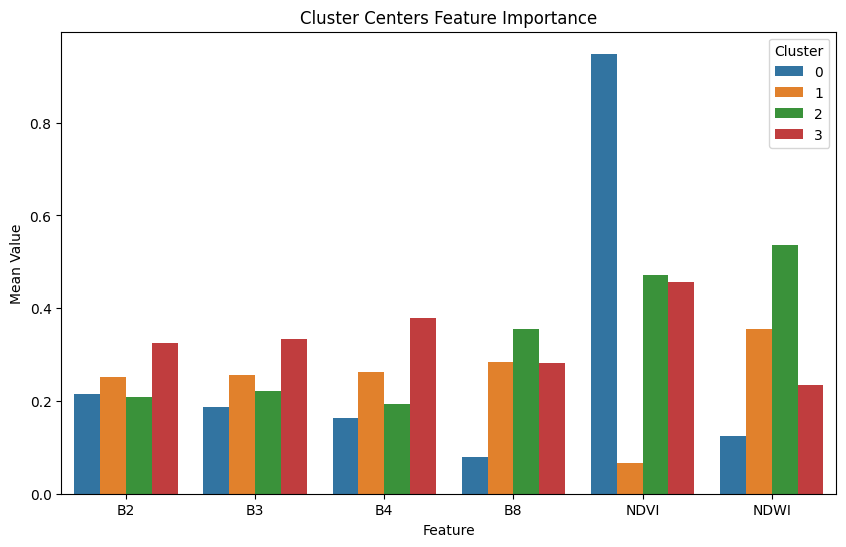

In [ ]:
import seaborn as sns
plt.figure(figsize=(10, 6))
df_melt = centers_df_normalized.reset_index().melt(id_vars='index')
sns.barplot(data=df_melt, x='variable', y='value', hue='index', palette='tab10')
plt.title("Cluster Centers Feature Importance")
plt.xlabel("Feature")
plt.ylabel("Mean Value")
plt.legend(title="Cluster")
plt.show()


A bar plot is displayed showing the pixel count for each cluster, helping to visualize the distribution of pixels across the clusters.